In [644]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import math

### Объявляем 
* плотность распределения числа просмотренных за сеанс страниц
* начальное состояние
* переходную матрицу

In [41]:
np.random.seed(1337)

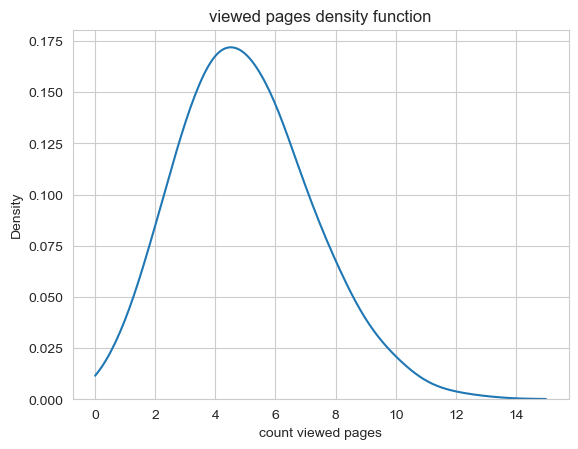

In [840]:
# число просмотренных за сеанс страниц
# в будущем данное распределение будет подаваться двумя списками:
# cnt_pages | cnt_views
s = np.random.poisson(5, 10000)
counts, frequency = np.unique(s, return_counts=True)
density = frequency / frequency.sum()

sns.set_style('whitegrid')
sns.kdeplot(s, bw_adjust=2, cut = 0)
plt.xlabel('count viewed pages')
plt.title('viewed pages density function')
plt.show()

In [836]:
# # уже не используется
# # начальное состояние (распределение вероятностей)
# min_val = 1
# cnt_pages = 228

# mean_offset, std_offset = np.random.randn(2,10)

# mean_offset = 0.5 * (mean + 3) 
# std_offset += 2

# mean = (min_val + max_val) / mean_offset
# std_dev = (max_val - min_val) / std_offset

# # Генерация дискретных значений
# q0 = np.arange(min_val, cnt_pages + 1)
# q0_probabilities = np.average(
#     a = np.array([np.exp(-0.5 * ((x - mean_item) / std_item) ** 2) for mean_item, std_item in zip(mean, std_dev)]),
#     axis = 0)

# q0_probabilities /= q0_probabilities.sum()

# plt.bar(q0, q0_probabilities, width=1.0, edgecolor='white')
# plt.title("Плотность вероятности индекса первой просмотренной страницы")
# plt.xlabel("Индекс")
# plt.ylabel("Вероятность")
# plt.show()

In [838]:
n = 228  # количество страниц
r = 11   # количество целевых действий

# 1. Вектор начальных состояний q0
q0 = np.zeros(n)
top_entry_pages = np.random.choice(n, size=5, replace=False)
q0[top_entry_pages] = np.random.dirichlet(np.ones(5), size=1)
q0 /= q0.sum()

# 2. Матрица переходов P
P = np.zeros((n, n))
main_page = np.random.randint(n)  # главная страница

for i in range(n):
    probs = np.random.dirichlet(np.ones(n) * 0.3)
    popular_targets = np.random.choice(n, size=2, replace=False)
    probs[main_page] += 2.0
    probs[popular_targets] += 1.0
    P[i] = probs / probs.sum()

# 3. Матрица целевых действий T
T = np.zeros((n, r))
for i in range(n):
    # вероятность совершить каждое из r действий на странице i
    action_probs = np.random.beta(a=2, b=5, size=r)  # чаще близко к 0, иногда выше
    T[i] = action_probs  # НЕ нормализуем, т.к. это независимые вероятности

# 4. Матрица стоимостей C
C = np.zeros((n, r))
for i in range(n):
    # средние стоимости действий на этой странице
    base_costs = np.random.uniform(10, 500, size=r)
    noise = np.random.normal(0, 10, size=r)
    C[i] = np.clip(base_costs + noise, 0, None)

# Результат:
print("q0 shape:", q0.shape)
print("P shape:", P.shape)
print("T shape:", T.shape)
print("C shape:", C.shape)


q0 shape: (228,)
P shape: (228, 228)
T shape: (228, 11)
C shape: (228, 11)


In [538]:
# вероятностная стоимость ЦД
TC = np.multiply(T, C)

# стоимость просмотра страницы
VC = np.sum(TC, axis = 1)

In [764]:
# распределение вероятностей посещения страницы на следующем шаге
def next_step_probability_distribution(current_distribution, P):
    return P.dot(current_distribution)

# матрица вероятностей, как склеенные вероятности посещения страницы
def probability_matrix(initial_distribution, P, cnt_steps):
    cnt_steps = int(cnt_steps)
    matrix = np.array([initial_distribution])
    current_distribution = initial_distribution
    
    for i in range(1, cnt_steps):
        current_distribution = next_step_probability_distribution(current_distribution, P)
        matrix = np.vstack([matrix, current_distribution])
    
    return matrix

# функция для расчета выручки в зависимости от шага
def step_revenue(PM, VC):
    return PM.dot(VC)

# расчет кумулятивно суммы выручки на каждом шаге
def cumsum_step_revenue(revenue_per_step):
    return np.cumsum(revenue_per_step)

In [726]:
def outliers_bounds(sample, iqr_offset = 1.5):
    quartile_1 = np.percentile(sample, 25)
    quartile_3 = np.percentile(sample, 75)
    
    iqr = quartile_3 - quartile_1
    
    upper_bound = quartile_3 + iqr_offset * iqr
    lower_bound = quartile_1 - iqr_offset * iqr

    return upper_bound, lower_bound

def sample_by_distribution(counts, frequency):
    return np.hstack([[count_]*frequency_ for count_, frequency_ in zip(counts, frequency)])

def distribution_by_sample(sample):
    return np.unique(sample, return_counts=True)

In [824]:
# тут важно, что в будущем входом будет csv-файл: cnt_pages | cnt_views
# функция для извлечения числа шагов из распределения и расчета доверительного интервала
def choice_step_cnt(counts, density, size):
    cnt_steps = np.random.choice(counts, size = size, replace = True, p = density)
    return cnt_steps

def revenue_interval_estimation(cnt_steps, revenue_cumsum, percentile = 95):
    revenue_arr = np.mean(
        np.array([revenue_cumsum[step - 1] for step in cnt_steps]),
        axis = 1
    )

    upp = 100 - (100 - percentile) / 2
    low = (100 - percentile) / 2
    
    upper_percentile = np.percentile(revenue_arr, 97.5)
    lower_percentile = np.percentile(revenue_arr, 2.5)
    mean = np.mean(revenue_arr)
    return mean, lower_percentile, upper_percentile

In [730]:
sample = sample_by_distribution(counts, frequency)

upper_bound = outliers_bounds(sample, iqr_offset = 1.5)[0]

sample = sample[sample < upper_bound]

counts, frequency = distribution_by_sample(sample)
density = frequency / frequency.sum()

In [794]:
PM = probability_matrix(q0, P, upper_bound)

revenue_by_step = step_revenue(PM, VC)

revenue_by_step_cumsum = cumsum_step_revenue(revenue_by_step)

In [826]:
cnt_steps = choice_step_cnt(counts, density, (10000, 1000))

In [834]:
mean, lower_percentile, upper_percentile = revenue_interval_estimation(cnt_steps, revenue_by_step_cumsum)
print(f'mean: {round(mean, 2)}')
print(f'lower percentile: {round(lower_percentile, 2)}')
print(f'upper percentile: {round(upper_percentile, 2)}')

mean: 2261.93
lower percentile: 2221.7
upper percentile: 2302.41


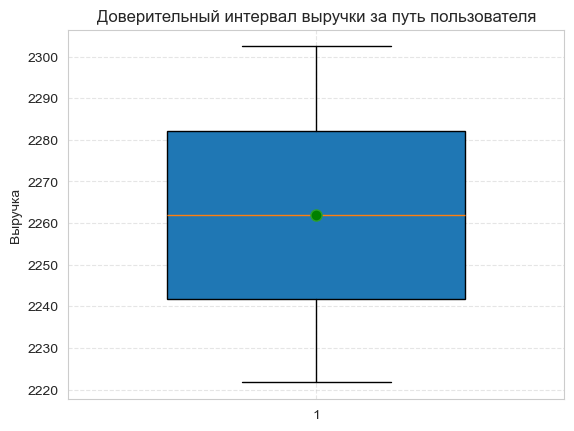

In [870]:
vis_data = [
    [lower_percentile, mean, upper_percentile]
]

plt.boxplot(
    vis_data,
    positions=[i+1 for i in range(len(vis_data))],
    widths=0.6,
    patch_artist=True,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "green", "markersize": 8},
)

plt.title("Доверительный интервал выручки за путь пользователя")
plt.ylabel("Выручка")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()